In [5]:
import numpy as np                                      
import matplotlib.pyplot as plt                         
# import matplotlib.patches as patches
# import seaborn as sns
# import scipy.signal as signal 
# from scipy.io import loadmat
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import loader_2015_epoch as loader2015
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.cuda.amp import autocast as autocast

from sklearn.metrics import classification_report, f1_score

In [6]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# If 'cuda:0' is printed, it means GPU is available.

cpu


In [7]:
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding='same'):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                                groups=in_channels, padding=padding)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 
                                kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class EEGNet(nn.Module):
    # expected input size: (batch_size, 32, 1, 128)
    def __init__(self, time_length, num_chans, output_size, dropout=0.25):
        super(EEGNet, self).__init__()
        self.time_length = time_length
        self.num_chans = num_chans
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(num_chans, 8, (1, 64), padding = 'same'),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 1, groups=8),
            nn.BatchNorm2d(16),
            nn.ELU(inplace=True),
            nn.AvgPool2d((1, 2)),
            nn.Dropout(dropout)
        )
        self.conv2 = nn.Sequential(
            SeparableConv2d(16, 16, (1, 32), padding = 'same'),
            nn.BatchNorm2d(16),
            # nn.Conv2d(256, 32, (1, 4), padding='same'),
            # nn.BatchNorm2d(32),
            nn.ELU(inplace=True),
            nn.AvgPool2d((1, 2)),
            nn.Dropout(dropout)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(512, output_size)
        )

    def forward(self, x):
        # reshape to (batch_size, 32, 1, 128)
        x = torch.reshape(x, (x.shape[0], self.num_chans, 1, self.time_length))
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [8]:
net = EEGNet(128, 32, 2)
net.to(device);

In [9]:
class_weights = [1, 6]
loss_func = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
#loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(), lr=0.001)

In [10]:
# Define our filter variables
fs = 512                      # Hz; sampling rate
dt = 1000. / fs                 # ms; time between samples
sdt = dt#np.round(dt).astype(int); # rounded dt so that we can index samples
hp = 1                        # Hz; our low cut for our bandpass
lp = 24.                        # Hz; our high cut for our bandpass
num_taps = 31                   # Number of taps/coefficients of FIR filter

# Create our filter coefficients
# Note: by defining 'fs' we don't divide our windows by the Nyquist
# Note: for FIR filters, a is always 1
# b = signal.firwin(numtaps=num_taps, cutoff=[hp, lp], pass_zero='bandpass', fs=fs)
# a = 1

# Define ERP-related variables
epoch_start = 0    # ms
epoch_end = 800    # ms
baseline_start = 0 # ms
baseline_end = 100 # ms
erp_start = 0    # ms
erp_end = 800      # ms

# Let's translate these from time into index space to save time later
e_s = np.round(epoch_start / sdt).astype(int)     # epoch start
e_e = np.round(epoch_end / sdt).astype(int)       # epoch end
bl_s = np.round(baseline_start / sdt).astype(int) # baseline start
bl_e = np.round(baseline_end / sdt).astype(int)   # baseline end
erp_s = np.round(erp_start / sdt).astype(int)     # ERP component window start
erp_e = np.round(erp_end / sdt).astype(int)       # ERP component window end

In [11]:
# load data
X_train, y_train = loader2015.load(1, 31)
X_test, y_test = loader2015.load(31, 44)

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0
print(np.unique(y_train, return_counts=True))

# pre-processing, inplace
def preprocess(x):
    for i in range(x.shape[0]):
        # correct DC offset of signal
        x[i] = x[i] - np.mean(x[i], axis=1).reshape(-1, 1)
        
        sd_every_chan = np.std(x[i], axis=1).reshape(-1, 1)
        x[i] = x[i] / sd_every_chan
        
        # bandpass filter
        #x[i] = signal.filtfilt(b, a, x[i], axis=1)
        # baseline correction
        #x[i] = x[i] - np.mean(x[i][bl_s:bl_e], axis=0)

preprocess(X_train)
preprocess(X_test)

num_points = 128; # we will divide our window into num_points means
# Define a simple windowed means function
def wm(x, start, end, num_points):
    num_trials = x.shape[0] # assumes first dem is numb observations
    num_chans = x.shape[1] # assumes last dim is num channels
    len_time = x.shape[2] # assumes second dim is time
    w = np.round((end-start)/num_points)
    y = np.zeros((num_trials, num_chans, num_points))
    for i in range(0, num_points):
        s = (start + (w * i))
        e = (s + w)
        if e > len_time:
            e = len_time
        y[:,:,i] = np.mean(x[:,:,s.astype(int):e.astype(int)], axis=2)
    return y

X_train = wm(X_train, erp_s, erp_e, num_points).astype(np.float32)
X_test = wm(X_test, erp_s, erp_e, num_points).astype(np.float32)

# transpose each epoch to (1, 128, 32)
tmp_x = []
for i in range(X_train.shape[0]):
    tmp_x.append(np.transpose(X_train[i]))
X_train = np.array(tmp_x)
tmp_x = []
for i in range(X_test.shape[0]):
    tmp_x.append(np.transpose(X_test[i]))
X_test = np.array(tmp_x)
del tmp_x

trainset = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
testset = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
trainloader = DataLoader(trainset, batch_size=512, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

(array([0., 1.]), array([40581,  8115]))


In [12]:
avg_losses = []   # Avg. losses.
epochs = min(320, int(7500000/trainloader.dataset.tensors[0].shape[0]))       # Total epochs.
print('Total epochs: {}'.format(epochs))
print_freq = 300  # Print frequency.

iter_count = 0

net.train()
for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        #with autocast():
        outputs = net(inputs)
        labels = labels.reshape(-1,).long()
        l = labels.cpu().numpy()
        # print(np.unique(l, return_counts=True))
        # print(outputs.shape, labels.shape)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if iter_count % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            avg_acc = (outputs.argmax(dim=1) == labels).float().mean()
            
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f} avg mini-batch acc: {:.3f}'.format(
                epoch, i, avg_loss, avg_acc))
            avg_losses.append(avg_loss)
            running_loss = 0.0
            
        iter_count += 1

print('Finished Training.')

Total epochs: 154


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552843/work/aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv2d(input, weight, bias, self.stride,


[epoch: 1, i:   108] avg mini-batch loss: 0.184 avg mini-batch acc: 0.723
[epoch: 3, i:    26] avg mini-batch loss: 0.044 avg mini-batch acc: 0.754
[epoch: 4, i:   135] avg mini-batch loss: 0.212 avg mini-batch acc: 0.711
[epoch: 6, i:    53] avg mini-batch loss: 0.082 avg mini-batch acc: 0.730
[epoch: 7, i:   162] avg mini-batch loss: 0.244 avg mini-batch acc: 0.789
[epoch: 9, i:    80] avg mini-batch loss: 0.120 avg mini-batch acc: 0.777
[epoch: 10, i:   189] avg mini-batch loss: 0.275 avg mini-batch acc: 0.773
[epoch: 12, i:   107] avg mini-batch loss: 0.155 avg mini-batch acc: 0.781
[epoch: 14, i:    25] avg mini-batch loss: 0.037 avg mini-batch acc: 0.824
[epoch: 15, i:   134] avg mini-batch loss: 0.187 avg mini-batch acc: 0.758
[epoch: 17, i:    52] avg mini-batch loss: 0.074 avg mini-batch acc: 0.754
[epoch: 18, i:   161] avg mini-batch loss: 0.221 avg mini-batch acc: 0.801
[epoch: 20, i:    79] avg mini-batch loss: 0.106 avg mini-batch acc: 0.836
[epoch: 21, i:   188] avg mini-

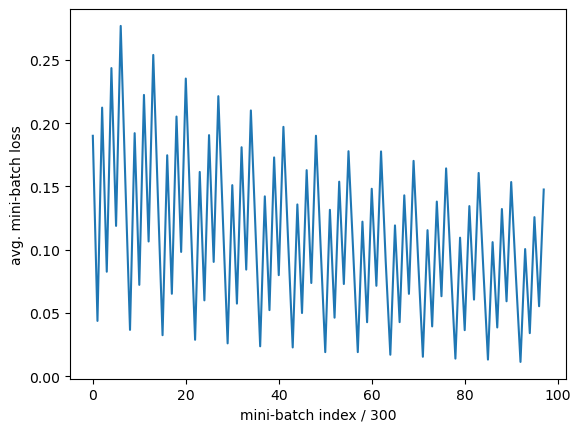

In [ ]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [ ]:
# Get test accuracy.
correct = 0
total = 0
net.eval()
y_pred = np.array([])
with torch.no_grad():
    for data in trainloader:
        x, y = data
        x, y = x.to(device), y.to(device)
        outputs = net(x)
        _, predicted = torch.max(outputs.data, 1)
        if correct % 5 == 1:
            print(np.unique(predicted.cpu().numpy(), return_counts=True))
        total += y.size(0)
        correct += (predicted == y).sum().item()
        y_pred = np.append(y_pred, predicted.cpu().numpy())

print('Accuracy on the testset: %d %%' % (
    100 * correct / total))


(array([0, 1]), array([190,  66]))
(array([0, 1]), array([197,  59]))
(array([0, 1]), array([192,  64]))
(array([0, 1]), array([211,  45]))
(array([0, 1]), array([189,  67]))
(array([0, 1]), array([194,  62]))
(array([0, 1]), array([198,  58]))
(array([0, 1]), array([192,  64]))
(array([0, 1]), array([210,  46]))
(array([0, 1]), array([192,  64]))
(array([0, 1]), array([187,  69]))
(array([0, 1]), array([194,  62]))
(array([0, 1]), array([209,  47]))
(array([0, 1]), array([199,  57]))
(array([0, 1]), array([178,  78]))
(array([0, 1]), array([203,  53]))
(array([0, 1]), array([193,  63]))
(array([0, 1]), array([191,  65]))
(array([0, 1]), array([197,  59]))
(array([0, 1]), array([201,  55]))
(array([0, 1]), array([182,  74]))
(array([0, 1]), array([193,  63]))
(array([0, 1]), array([184,  72]))
(array([0, 1]), array([187,  69]))
(array([0, 1]), array([194,  62]))
(array([0, 1]), array([191,  65]))
(array([0, 1]), array([199,  57]))
(array([0, 1]), array([195,  61]))
(array([0, 1]), arra

In [ ]:
print(np.unique(y_pred, return_counts=True))
y_test = trainloader.dataset.tensors[1].numpy()
print(np.unique(y_test, return_counts=True))
print(f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
print("tn, fp, fn, tp", confusion_matrix(y_test, y_pred).ravel())

(array([0., 1.]), array([37133, 11563]))
(array([0., 1.]), array([40581,  8115]))
0.49312418498444666
              precision    recall  f1-score   support

         0.0       0.83      0.76      0.80     40581
         1.0       0.16      0.23      0.19      8115

    accuracy                           0.67     48696
   macro avg       0.50      0.50      0.49     48696
weighted avg       0.72      0.67      0.69     48696

tn, fp, fn, tp [30898  9683  6235  1880]


In [ ]:
# Get test accuracy.
correct = 0
total = 0
net.eval()
y_pred = np.array([])
with torch.no_grad():
    for data in testloader:
        x, y = data
        x, y = x.to(device), y.to(device)
        outputs = net(x)
        _, predicted = torch.max(outputs.data, 1)
        if correct % 5 == 1:
            print(np.unique(predicted.cpu().numpy(), return_counts=True))
        total += y.size(0)
        correct += (predicted == y).sum().item()
        y_pred = np.append(y_pred, predicted.cpu().numpy())

print('Accuracy on the testset: %d %%' % (
    100 * correct / total))


In [ ]:
print(np.unique(y_pred, return_counts=True))
y_test = testloader.dataset.tensors[1].numpy()
print(np.unique(y_test, return_counts=True))
print(f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
print("tn, fp, fn, tp", confusion_matrix(y_test, y_pred).ravel())

(array([0., 1.]), array([37133, 11563]))
(array([0., 1.]), array([18990,  3798]))


ValueError: Found input variables with inconsistent numbers of samples: [22788, 48696]